In [17]:
import os
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import roc_auc_score, mean_squared_error

import shap


import warnings
warnings.filterwarnings('ignore')

# Leitura dos artefatos

In [5]:
model = pickle.load(
    open('../models/wrapped/model_clf_pipeline_prod.pkl', 'rb')
)
model


Pipeline(steps=[('json_to_df', Conversor de JSON),
                ('seletor_1',
                 Seletor de variáveis. Modo: train. Features: ['accepts_mercadopago', 'attributes_color_value', 'attributes_main_color_value', 'available_quantity', 'buying_mode', 'catalog_listing', 'condition', 'currency_id', 'installments_quantity', 'listing_type_id', 'price_tratado', 'sale_price_conditions_eligible', 'sa...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.079548, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=13.336635,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=-1, num_parallel_tree=None,
                               random_state=12, ...))])

In [6]:
model_reg = pickle.load(
    open('../models/wrapped/model_reg_pipeline_prod.pkl', 'rb')
)
model_reg

Pipeline(steps=[('json_to_df', Conversor de JSON),
                ('seletor_1',
                 Seletor de variáveis. Modo: train. Features: ['attributes_color_value', 'available_quantity', 'catalog_listing', 'currency_id', 'installments_quantity', 'listing_type_id', 'price_tratado', 'sale_price_metadata_promotion_type', 'shipping_free_shipping', 'shipping_logistic_type', 'site_id']),
                ('cria_features...
                              gamma=0.018385, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.098695, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=0.373927, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=12, ...))])

# Classificação de promoção

## Leitura das bases (treino e teste)

In [80]:
df_treino = pd.read_parquet(os.path.join('..', 'data', 'train_test', 'train_promotion_clf.parquet'))

print(df_treino.shape)
df_treino.head()

(212047, 36)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,shipping_free_shipping,shipping_logistic_type,address_city_name,address_state_name,installments_quantity,price_tratado,category_id_tratado,domain_id_tratado,installments_price,promotion_flag
0,MLU668573170,Urna Cremación Un Cuerpo,new,839942-MLU45689652142_042021,None,gold_special,https://articulo.mercadolibre.com.uy/MLU-66857...,buy_it_now,MLU,MLU3530,...,False,not_specified,cerrito,montevideo,NaN,1350.00,3530,UNCLASSIFIED_PRODUCTS,NaN,0
1,MLV822248230,Casa En Venta En Prados Del Este Caracas Pisci...,used,904896-MLV81582064102_012025,None,gold_premium,https://casa.mercadolibre.com.ve/MLV-822248230...,classified,MLV,MLV1468,...,False,None,caracas - baruta (sur),distrito capital,NaN,1200000.00,1468,INDIVIDUAL_HOUSES_FOR_SALE,NaN,0
2,MPE632401540,"Botines, Zapatos De Cuero De Mujer Caterpilla",new,825727-MPE73313489505_122023,None,gold_pro,https://articulo.mercadolibre.com.pe/MPE-63240...,buy_it_now,MPE,MPE415193,...,True,drop_off,lima,lima metropolitana,12.0,240.00,415193,FOOTWEAR,20.0,1
3,MLU479054461,Tunicas Bata Descartable Sobretunica Tnt 40gr...,new,876109-MLU45781746095_052021,None,gold_special,https://articulo.mercadolibre.com.uy/MLU-47905...,buy_it_now,MLU,MLU184442,...,False,cross_docking,cordon,montevideo,NaN,519.00,184442,WORK_SCRUBS,NaN,0
4,MLV756623909,"Juguete De Cangrejo Con Movimientos, Música, R...",new,974293-MLV75637218812_042024,None,bronze,https://articulo.mercadolibre.com.ve/MLV-75662...,buy_it_now,MLV,MLV445847,...,True,not_specified,naguanagua (naguanagua),carabobo,NaN,22.99,445847,BABY_SUPPLIES,NaN,0


In [81]:
df_teste = pd.read_parquet(os.path.join('..', 'data', 'train_test', 'test_promotion_clf.parquet'))

print(df_teste.shape)
df_teste.head()

(53012, 36)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,shipping_free_shipping,shipping_logistic_type,address_city_name,address_state_name,installments_quantity,price_tratado,category_id_tratado,domain_id_tratado,installments_price,promotion_flag
0,MPE659558458,Camara Sport Hd 1080p Pantalla 2 PuLG Inch Acu...,new,606427-MPE72669754247_112023,None,gold_pro,https://articulo.mercadolibre.com.pe/MPE-65955...,buy_it_now,MPE,MPE1042,...,False,drop_off,magdalena del mar,lima metropolitana,12.0,78.00,1042,DIGITAL_CAMERAS,6.500000,0
1,MLV789023246,Vasos De Entrenamiento,new,725857-MLV75163116469_032024,None,gold_special,https://articulo.mercadolibre.com.ve/MLV-78902...,buy_it_now,MLV,MLV446311,...,True,not_specified,mun. chacao (sur),distrito capital,NaN,13.64,446311,BABY_CUPS_AND_MUGS,NaN,1
2,MCO2320467408,Moneda F-16 De La Fuerza Aérea De Los Estados ...,new,601679-MCO75741223731_042024,None,gold_special,https://articulo.mercadolibre.com.co/MCO-23204...,buy_it_now,MCO,MCO9355,...,False,fulfillment,teusaquillo,bogota d.c.,3.0,40000.00,9355,COINS,13333.333333,0
3,MLV758737823,Nintendo Dsi Xl,used,783211-MLV69947741285_062023,MLV6107949,bronze,https://articulo.mercadolibre.com.ve/MLV-75873...,buy_it_now,MLV,MLV2922,...,False,not_specified,mun. baruta (este),distrito capital,NaN,80.00,2922,GAME_CONSOLES,NaN,0
4,MLV820609222,Nexgard Pastilla Antipulgas Perros 10-25kg 1 C...,new,776043-MLV81183176046_122024,None,gold_special,https://articulo.mercadolibre.com.ve/MLV-82060...,buy_it_now,MLV,MLV278239,...,True,not_specified,mun. libertador (centro),distrito capital,NaN,20.00,278239,PET_ANTIPARASITICS,NaN,0


In [118]:
seletor = pickle.load(
    open(os.path.join('..', 'models', 'encoders', 'seletor_2.pkl'), 'rb')
)

## Scoring

In [82]:
df_treino['score'] = (model.predict_proba(df_treino)[:,1]*1000).astype(int)
df_teste['score'] = (model.predict_proba(df_teste)[:,1]*1000).astype(int)

## Evaluation

In [83]:
roc_auc_score(
    df_treino['promotion_flag'],
    df_treino['score']/1000
)

0.8635938107371419

In [84]:
roc_auc_score(
    df_teste['promotion_flag'],
    df_teste['score']/1000
)

0.8620567862000172

## Análise de resultados

Para analisar os resultados obtidos do modelo de classificação, optou-se por trabalhar com o score no intervalo inteiro de $[0, 1000]$. Posteriormente, quebrou-o em decis e, então, calculou o recall (FPR) e a precisão (ou hit rate). Note que, para o decil 8 há, aproximadamente, 70% das promoções e 40% de precisão, para uma região em que há somente 22% de produtos que não deveriam ser promoções. Assim, considerou-se que o modelo é bastante satisfatório.

Isso significa que, com o auxílio do modelo, a pessoa responsável por propor as promoções poderia concentrar sua análise em apenas 20% dos produtos, ao invés de analisar a totalidade, e ainda assim capturar 70% dos produtos promocionais nesse grupo prioritário.

In [115]:
df_teste['decil'] = pd.qcut(df_teste['score'], q=10, labels=False, duplicates='drop')
results = (df_teste.groupby('decil').promotion_flag.sum()/df_teste.promotion_flag.sum()).reset_index()
results['decil'] += 1

results

,quantile,promotion_flag
0,1,0.000000
1,2,0.000000
2,3,0.003521
3,4,0.032250
4,5,0.059059
5,6,0.095951
6,7,0.126681
7,8,0.160291
8,9,0.251841
9,10,0.270407


In [116]:
results['promo_items'] = df_teste[df_teste.promotion_flag == 1].groupby('decil').size()
results['total_items'] = df_teste.groupby('decil').size().astype(int)
results['no_promo_items'] = results['total_items'] - results['promo_items']
results['score (>=)'] = round(df_teste.groupby('decil').score.min(), 3)

results.fillna(0, inplace=True)
results.sort_values(by='decil', ascending=False, inplace=True)
results = results[['decil', 'score (>=)', 'promo_items', 'no_promo_items', 'total_items', 'promotion_flag']]

In [117]:
results = results.rename(columns={'promotion_flag': 'recall'})

results['recall'] = results['recall'].cumsum()
results['precision'] = results['promo_items'] / results['total_items']
results['no_promo_items'] = results['no_promo_items'].cumsum()
results['total_items'] = results['total_items'].cumsum()

results.reset_index(drop=True, inplace=True)

results


,quantile,score (>=),promo_items,no_promo_items,total_items,recall,precision
0,10,992,3379.0,1108.0,4487,0.270407,0.753064
1,9,986,3147.0,3692.0,10218,0.522247,0.549119
2,8,980,2003.0,6746.0,15275,0.682538,0.396085
3,7,971,1583.0,10602.0,20714,0.809219,0.291046
4,6,957,1199.0,15117.0,26428,0.905170,0.209835
5,5,921,738.0,19692.0,31741,0.964229,0.138905
6,4,740,403.0,24656.0,37108,0.996479,0.075089
7,3,6,44.0,29876.0,42372,1.000000,0.008359
8,2,2,0.0,29876.0,45501,1.000000,0.000000
9,1,0,0.0,29876.0,53012,1.000000,0.000000


Em relação à importância das features, o preço real do produto (`price_tratado`) se destaca, seguido pelo valor mínimo da parcela do produto (`installments_price`). Por outro lado, os valores SHAP, que utilizam uma abordagem diferente para calcular a importância das features em comparação com a métrica de importância gerada pelo próprio modelo, apontam que a elegibilidade do produto (`sale_price_condition_eligible`) é a features mais relevante, enquanto a aceitação do Mercado Pago (accepts_mercadopago) ocupa a segunda posição como features de maior importância.

In [119]:
importance = model[-1].get_booster().get_score(importance_type = 'weight')

df_imp = pd.DataFrame({
    'feature': seletor.features,
    'imp': importance.values()
}).sort_values(by='imp', ascending=False)

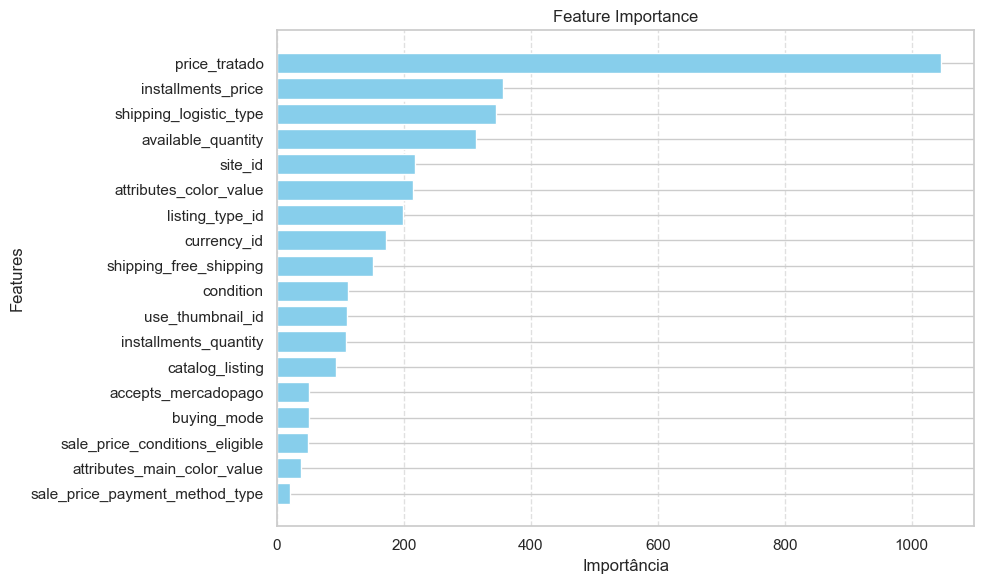

In [120]:
plt.figure(figsize=(10, 6))

plt.barh(df_imp['feature'], df_imp['imp'], color = 'skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)

plt.tight_layout()
plt.show()

In [127]:
df_treino_encoded = pd.read_parquet(os.path.join('..', 'data', 'train_test', 'train_encoded_clf.parquet'))
sample_train = df_treino_encoded[seletor.features].sample(frac = 0.3, random_state=98)

100%|===================| 63378/63614 [03:30<00:00]        

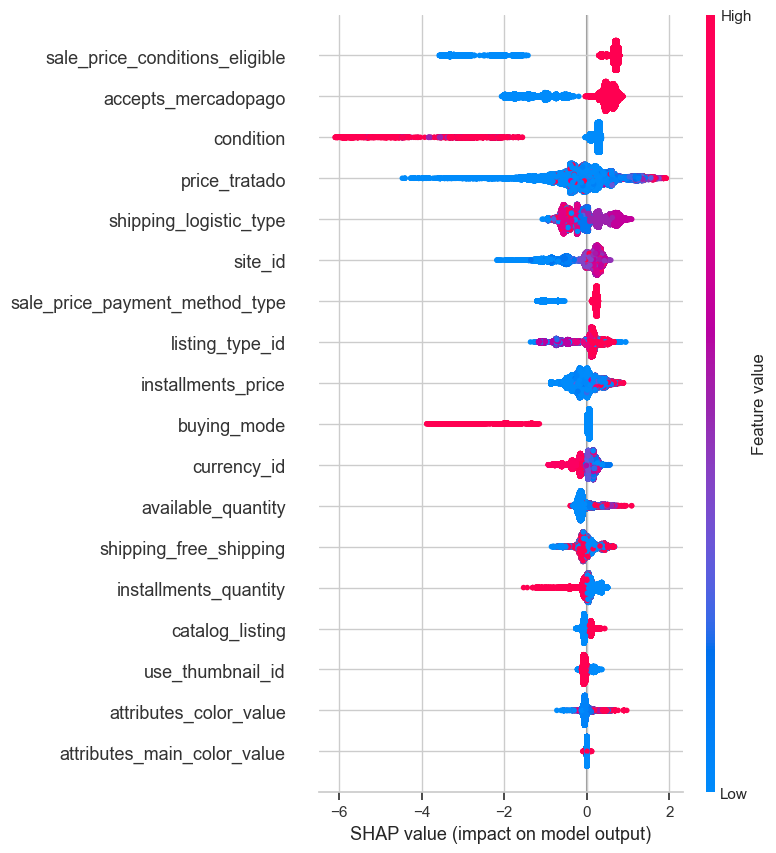

In [128]:
explainer = shap.Explainer(model[-1], sample_train)
shap_values = explainer(sample_train)

plt.figure(figsize = (10, 6))
shap.summary_plot(shap_values, sample_train)

# Predição do desconto da promoção

## Leitura das bases (treino e teste)

In [2]:
df_treino_reg = pd.read_parquet(os.path.join('..', 'data', 'train_test', 'train_promotion_reg.parquet'))

print(df_treino_reg.shape)
df_treino_reg.head()

(49407, 37)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,shipping_free_shipping,shipping_logistic_type,address_city_name,address_state_name,installments_quantity,price_tratado,category_id_tratado,domain_id_tratado,installments_price,discount
0,MLU479851199,Pulseras Esclavas Para Parejas His Queen Her King,new,702091-MLU46286789444_062021,None,gold_special,https://articulo.mercadolibre.com.uy/MLU-47985...,buy_it_now,MLU,MLU188647,...,False,cross_docking,centro,montevideo,NaN,590.0,188647,BRACELETS_AND_ANKLE_BRACELETS,NaN,0.100000
1,MLU653450002,Silla De Escritorio Meetion Chr15 Mt-chr15 Gam...,new,950198-MLA45372964153_032021,MLU17434815,gold_special,https://www.mercadolibre.com.uy/silla-de-escri...,buy_it_now,MLU,MLU447782,...,True,cross_docking,centro,montevideo,NaN,305.0,447782,OFFICE_CHAIRS,NaN,0.100000
2,MCO2209369810,Cinta Ancha Adhesiva Transparent X 6 Rollos Em...,new,770242-MLU78453358709_082024,MCO32624832,gold_pro,https://www.mercadolibre.com.co/cinta-ancha-ad...,buy_it_now,MCO,MCO432777,...,False,fulfillment,medellin,antioquia,12.0,49625.0,432777,ADHESIVE_TAPES,4135.416667,0.220010
3,MCO1418614159,Escalera Plegable 2 Pasos Acero Capacidad 150k...,new,610806-MCO76090689635_042024,None,gold_pro,https://articulo.mercadolibre.com.co/MCO-14186...,buy_it_now,MCO,MCO172892,...,True,drop_off,martires,bogota d.c.,12.0,147900.0,172892,LADDERS,12325.000000,0.330000
4,MLB4825917896,Cd Marilyn Manson - The Pale Amperor Versão Do...,new,807183-MLU77443567525_072024,MLB22507487,gold_pro,https://www.mercadolivre.com.br/cd-marilyn-man...,buy_it_now,MLB,MLB1174,...,False,xd_drop_off,osasco,sao paulo,3.0,34.9,1174,MUSIC_ALBUMS,11.633333,0.050143


In [3]:
df_teste_reg = pd.read_parquet(os.path.join('..', 'data', 'train_test', 'test_promotion_reg.parquet'))

print(df_teste_reg.shape)
df_teste_reg.head()

(12352, 37)


,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,shipping_free_shipping,shipping_logistic_type,address_city_name,address_state_name,installments_quantity,price_tratado,category_id_tratado,domain_id_tratado,installments_price,discount
0,MLB3504880157,Relógio De Parede Nativo Quartz Redondo Com Bo...,new,735537-MLB72687698250_112023,None,gold_special,https://produto.mercadolivre.com.br/MLB-350488...,buy_it_now,MLB,MLB118028,...,False,fulfillment,januaria,minas gerais,12.0,40.00,118028,WALL_CLOCKS,3.333333,0.370000
1,MCO1379670817,Escalera Tijera #9 Peldaños Pasos 2.70 Metros ...,new,988926-MCO73825993042_012024,None,gold_pro,https://articulo.mercadolibre.com.co/MCO-13796...,buy_it_now,MCO,MCO172892,...,True,not_specified,pereira,risaralda,12.0,459000.00,172892,LADDERS,38250.000000,0.100000
2,MPE688645524,Cubre Cinturon Negro Sparco Opc12120001 Color ...,new,902068-MLU71149664095_082023,MPE26207439,bronze,https://www.mercadolibre.com.pe/cubre-cinturon...,buy_it_now,MPE,MPE430923,...,False,drop_off,san martin de porres,lima metropolitana,12.0,76.21,430923,VEHICLE_SEAT_BELT_COVERS,6.350833,0.428553
3,MPE681847530,Antipulgas Para Perro Nexgard Spectra 15 A 30 ...,new,728550-MPE78246433185_082024,MPE27220177,bronze,https://articulo.mercadolibre.com.pe/MPE-68184...,buy_it_now,MPE,MPE278239,...,True,drop_off,miraflores,lima metropolitana,12.0,240.00,278239,PET_ANTIPARASITICS,20.000000,0.370833
4,MLB5202752050,Gaviz V 10mg - Omeprazol C/ 50 Comprimidos,new,753123-MLU73125323998_122023,MLB21808551,gold_special,https://www.mercadolivre.com.br/gaviz-v-10mg-o...,buy_it_now,MLB,MLB270514,...,False,fulfillment,sao paulo,sao paulo,12.0,114.99,270514,CAT_AND_DOG_SUPPLEMENTS,9.582500,0.343421


In [69]:
seletor = pickle.load(
    open(os.path.join('..', 'models', 'encoders_reg', 'seletor_2.pkl'), 'rb')
)

## Scoring

In [7]:
df_treino_reg['target_predict'] = model_reg.predict(df_treino_reg)
df_teste_reg['target_predict'] = model_reg.predict(df_teste_reg)

## Evaluation

In [53]:
np.sqrt(
        mean_squared_error(
        df_treino_reg['discount'],
        df_treino_reg['target_predict']
    )
)

0.11504052032124898

In [54]:
np.sqrt(
    mean_squared_error(
        df_teste_reg['discount'],
        df_teste_reg['target_predict']
    )
)

0.11796435702289823

## Análise de resultados

Dos gráficos abaixo, nota-se que o modelo apresentou um desempenho mediano, subestimando o valor do desconto na maioria das vezes. No entanto, analisando o gráfico de resíduos, a diferença absoluta do desconto real e do desconto predito ficou no intervalo [0, 0.10] em, aproximadamente, $63\%$. Ou seja, aproximadamente $63\%$ dos produtos em promoção tiveram o valor do desconto diferente do real em até 10p.p.

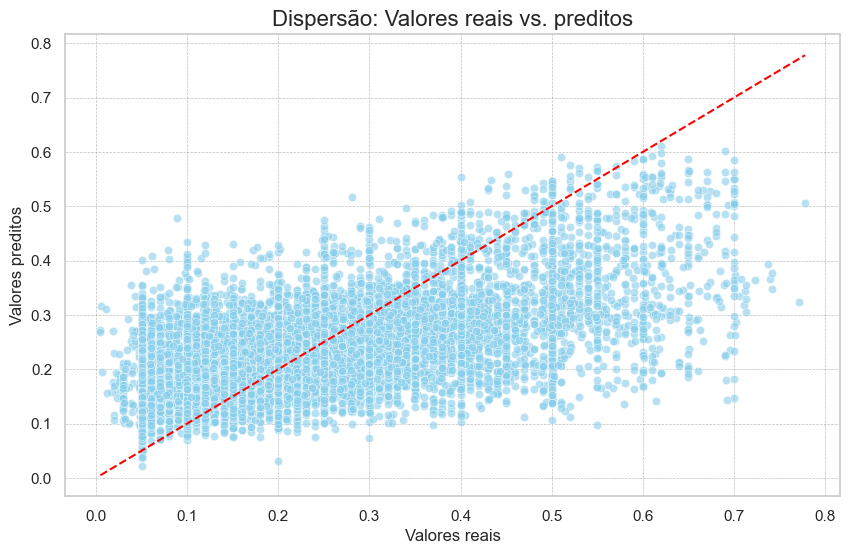

In [55]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid") 

sns.scatterplot(
    x = df_teste_reg['discount'], 
    y = df_teste_reg['target_predict'], 
    alpha = 0.6, 
    color = "skyblue"
)

min_val = min(np.min(df_teste_reg['discount']), np.min(df_teste_reg['target_predict']))
max_val = max(np.max(df_teste_reg['discount']), np.max(df_teste_reg['target_predict']))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1.5)

plt.xlabel('Valores reais', fontsize = 12)
plt.ylabel('Valores preditos', fontsize = 12)
plt.title('Dispersão: Valores reais vs. preditos', fontsize = 16)

plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.show()

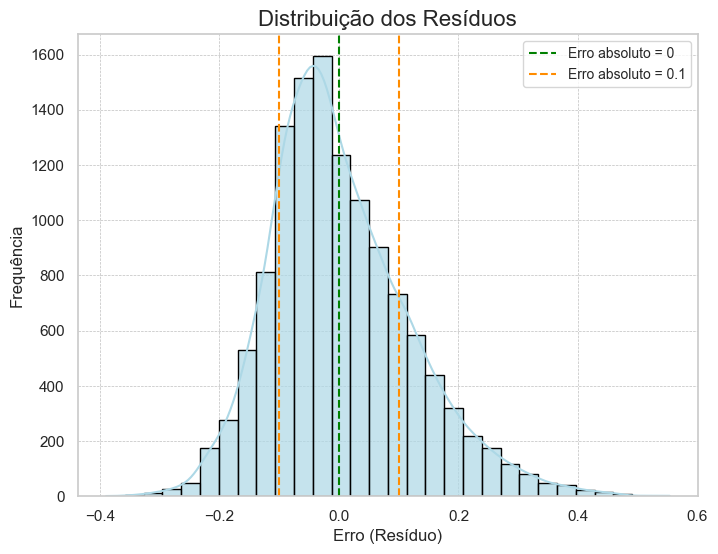

In [63]:
residuals = df_teste_reg['discount'] - df_teste_reg['target_predict']

plt.figure(figsize = (8, 6))

sns.set_theme(style = "whitegrid") 
sns.histplot(residuals, bins = 30, kde = True, color = "lightblue", edgecolor = "black", alpha=0.7)
plt.title('Distribuição dos Resíduos', fontsize = 16)
plt.xlabel('Erro (Resíduo)', fontsize = 12)
plt.ylabel('Frequência', fontsize = 12)

plt.axvline(0, color = 'green', linestyle = '--', linewidth = 1.5, label = 'Erro absoluto = 0')
plt.axvline(-0.1, color = 'darkorange', linestyle = '--', linewidth = 1.5, label = 'Erro absoluto = 0.1')
plt.axvline(0.1, color = 'darkorange', linestyle = '--', linewidth = 1.5)
plt.legend(fontsize = 10)

plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'gray', alpha=0.5)
plt.show()

In [66]:
len(residuals[abs(residuals) < 0.1]) / len(residuals)

0.6337435233160622

No que diz respeito à importância das variáveis, o preço real (`price_tratado`) do produto se destaca e, consequentemente, o valor mínimo da parcela do produto (`installments_price`). Por sua vez, os valores SHAP, que possuem um método diferente de calcular a importância de uma variável quando comparado ao feature importance do próprio modelo, também considera o valor real do produto como sendo a variável mais importante, no entanto, a segunda posição difere do método anterior, que passa a ser a feature referente a entrega grátis do produto (`shipping_free_shipping`), cuja interpretação é: valores alto dessa feature (ou seja, se é 1, uma vez que é binária) está associado a um menor valor do desconto predito.

In [78]:
importance = model_reg[-1].get_booster().get_score(importance_type = 'weight')

df_imp = pd.DataFrame({
    'feature': seletor.features,
    'imp': importance.values()
}).sort_values(by='imp', ascending=False)

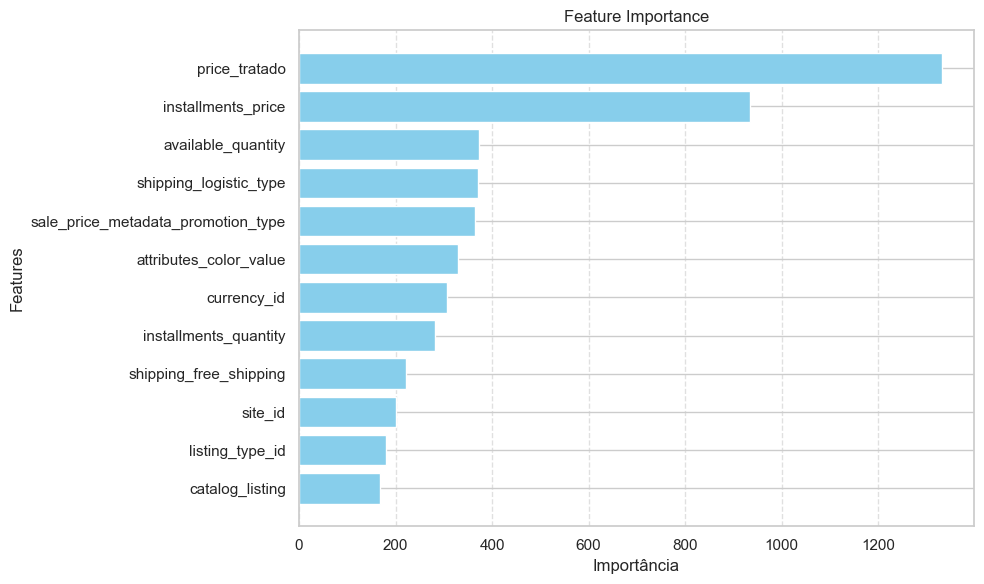

In [ ]:
plt.figure(figsize=(10, 6))

plt.barh(df_imp['feature'], df_imp['imp'], color = 'skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)

plt.tight_layout()
plt.show()

In [67]:
df_treino_reg_encoded = pd.read_parquet(os.path.join('..', 'data', 'train_test', 'train_encoded_reg.parquet'))

100%|===================| 49358/49407 [03:05<00:00]        

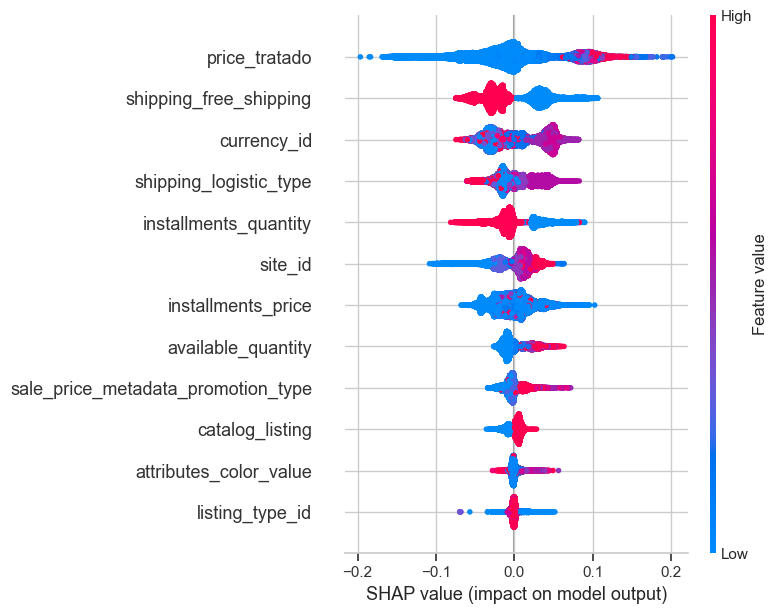

In [68]:
explainer = shap.Explainer(model_reg[-1], df_treino_reg_encoded[seletor.features])
shap_values = explainer(df_treino_reg_encoded[seletor.features])

plt.figure(figsize = (10, 6))
shap.summary_plot(shap_values, df_treino_reg_encoded[seletor.features])